<span style="color:grey">Author:</span>
<span style="color:yellow">Guillem Borràs</span>

<span style="color:grey">Github</span>: @guiillem_10

<span style="color:grey">Linkedin</span>: https://www.linkedin.com/in/guillem-borras/


---

# 📊 Quantitative Analysis of Sustainable (ESG) ETFs in Europe and the U.S.

This notebook is part of a broader quantitative finance project.  
In this section, we focus on **Exchange-Traded Funds (ETFs) with a strong sustainability (ESG) profile**, selected from **European and U.S. markets**, with the goal of evaluating their historical performance and risk profile compared to traditional market benchmarks.

---

## 🎯 Specific Objectives

1. **Download and clean historical price data** for ESG ETFs and benchmarks (S&P 500, MSCI Europe, etc.) via `yfinance`.
2. **Compute key performance and risk metrics**:  
   - Annualized return and volatility  
   - Sharpe, Sortino, and Calmar ratios  
   - Maximum drawdown, hit ratio, historical VaR and CVaR  
   - Beta and correlation with the benchmark  
3. **Statistical analysis of returns**:
   - Fit Normal and Student-t distributions  
   - Assess skewness and kurtosis  
4. **Conditional volatility modeling** using **GARCH(1,1)** models with both normal and t-Student innovations.
5. **Visualization and automated commentary** to synthesize key findings and communicate results clearly and professionally.

---

## 🔍 Added Value

This analysis aims to answer questions such as:
- Have sustainable ETFs delivered returns and risk profiles comparable to their benchmarks?
- Do they exhibit lower volatility or smaller drawdowns during crises?
- Do their returns follow a normal distribution, or do they exhibit fat tails?
- How does their volatility evolve over time, and how persistent is it?

The notebook combines **advanced quantitative techniques** with **intuitive visualizations** and **automated commentary**, demonstrating a professional approach to financial asset analysis.


---

#### ETF Selection and Analysis Scope

This analysis covers a **multi-asset, multi-region** set of ETFs: four from the **United States** and five from the **Eurozone**. The lineup blends equities (broad market, ESG, and small/mid caps) with **investment-grade credit** and **inflation-linked** exposure to illustrate diversification across asset classes and regions.

**U.S. selection (equity + credit):**
- **ESGU** — broad U.S. equity with an **ESG tilt** (large/mid caps).  
- **SMMD** — U.S. **small/mid-cap** equities (Russell 2500-like exposure).  
- **IGEB** — U.S. **investment-grade corporate bonds** (systematic selection).  
- **VTC** — U.S. **total corporate bond** exposure (aggregate IG across maturities).

**Eurozone selection (equity + credit/linked):**
- **UIMR.DE** — Eurozone **equities** (broad, market-cap weighted).  
- **EXW1.DE** — **EURO STOXX 50** core equity exposure (blue chips).  
- **ESEG.MI** — Eurozone **equities with an ESG screen/tilt**.  
- **IUSG** — **EUR investment-grade corporate bonds**.  
- **XEIN.DE** — **Euro inflation-linked government bonds**.

---

**Benchmarks (primary regional references used in the notebook):**  
- **United States (equities):** **S&P 500** (**^GSPC**).  
- **Eurozone (equities):** **EURO STOXX 50** (**^STOXX50E**).

> *Note:* The universe includes **fixed-income** ETFs (IGEB, VTC, IUSG, XEIN.DE). While they’re not equity indices, we keep the **regional equity benchmarks** above for consistent cross-asset plots. 
---

**Selection rationale**  
The set spans: (i) **broad market exposure** (EXW1.DE, UIMR.DE), (ii) **ESG-tilted equity** (ESGU, ESEG.MI), (iii) a **size tilt** (SMMD), and (iv) **investment-grade credit and inflation-linked** defenses (IGEB, VTC, IUSG, XEIN.DE). This mix is designed to:
- capture **regional equity beta** (U.S. vs. Eurozone),
- add **style/ESG** tilts that typically keep **low tracking error** vs. parent indices,
- introduce **cross-asset diversification** via corporate credit and inflation-linked govies, which tend to show **lower (sometimes negative) correlation** with equities during stress.

---

**Analysis period**  
We focus on **2018–present** (daily data). This window ensures a consistent live history for all tickers, spanning multiple regimes (late-cycle rally, the 2020 COVID shock, the 2022 inflation/rate-hike regime, and subsequent recoveries). It is long enough to evaluate **risk-adjusted performance** (volatility, drawdowns, Sharpe/Sortino) and **co-movement** (correlations/beta) across assets and regions.

---

**Benchmarking approach (practical)**  
Each regional run uses a **single primary benchmark** (S&P 500 for the U.S. group; EURO STOXX 50 for the Eurozone group) to keep charts/tables consistent. Equity ETFs are assessed **relative to** their regional benchmark; **fixed-income** ETFs are shown **alongside** the same benchmark for context, with interpretation driven by their own risk drivers and by **pairwise stats** rather than equity out/under-performance.

In [153]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from utils import (download_analyze_with_metrics, plot_prices, plot_returns, fit_models_from_panel,
                   plot_hist_stdres_garch, plot_hist_with_pdf_normal_t, plot_hist_with_spline, 
                   plot_hist_with_kde, gaussian_qq_acf_diagnostics, student_t_qq_acf_diagnostics,
                   garch_diagnostics, compute_tracking_metrics)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The historical price and return data used in this analysis will be obtained through the custom-built function **`download_analyze_with_metrics`**, a highly versatile and robust tool specifically designed for quantitative financial research.  

This function offers a **full data pipeline in a single call**:

1. **Automated data download** – Retrieves historical price data for any list of tickers directly from Yahoo Finance, including optional benchmark series, using the `yfinance` API.
2. **Advanced data cleaning** –  
   - Handles missing values intelligently (forward/backward fill within a limit).  
   - Removes non-trading anomalies and constant series.  
   - Ensures positive prices and proper date alignment across assets.  
3. **Return computation** – Computes both simple and log returns, with optional *winsorization* to control the impact of extreme outliers.  
4. **Risk and performance metrics** – Generates a comprehensive **per-asset summary table** including:  
   - Annualized log-return $r_t = log(P_{t+1}/P_t)$ & volatility  
   - Sharpe, Sortino, and Calmar ratios  
   - Maximum drawdown & time in drawdown  
   - Historical and parametric VaR/CVaR  
   - Skewness & excess kurtosis  
   - Beta, alpha, and correlation with the benchmark  
5. **Additional analytics** – Returns a dictionary of extras, such as:  
   - Individual drawdown series  
   - Correlation matrix across assets  
   - Rolling volatility and Sharpe ratio windows  
6. **Automated commentary (optional)** – Uses `generate_financial_commentary` to produce a ready-to-use, plain-language narrative summarizing the key statistics for all assets analyzed.

**Why it stands out:**  
`download_analyze_with_metrics` is essentially **an end-to-end market analysis engine**.  
It encapsulates multiple steps that would normally require dozens of lines of code — data ingestion, cleaning, transformation, metric computation, and high-level interpretation — into a single, reproducible call.  
Its flexibility in handling different cleaning parameters, return types, and benchmark integration makes it **one of the most powerful and time-efficient functions in this project**, and a cornerstone for building professional-grade financial analytics workflows.


In [154]:
tickers_us = ['ESGU', 'IGEB', 'SMMD', 'VTC']
tickers_eu   = ['UIMR.DE', 'IUSG', 'ESEG.MI', 'EXW1.DE', 'XEIN.DE']
benchmark_us = '^GSPC'
benchmark_eu = '^STOXX50E'

In [155]:
start_date = '2018-01-01'
rf_annual = 0.02
ret_method = 'log'
winsor = None

In [156]:
panel_us, summary_us, extras_us, commentary_us = download_analyze_with_metrics(
    tickers=tickers_us,
    start_date=start_date,
    benchmark=benchmark_us,
    rf_annual=rf_annual,
    periods_per_year=252,
    auto_adjust=True,
    winsorize_returns=winsor,
    return_method=ret_method,
    make_commentary=True,
    benchmark_name_for_comment="S&P 500",
    return_units_for_comment="daily"
)

In [157]:
panel_eu, summary_eu, extras_eu, commentary_eu = download_analyze_with_metrics(
    tickers=tickers_eu,
    start_date=start_date,
    benchmark=benchmark_eu,                
    rf_annual=rf_annual,
    periods_per_year=252,
    auto_adjust=True,
    winsorize_returns=winsor,
    return_method=ret_method,
    make_commentary=True,
    benchmark_name_for_comment="Euro Stoxx 50",
    return_units_for_comment="daily"
)

Some quick sanity prints to check time series downloads have been succesfull:

In [158]:
print("US tickers:", tickers_us, "| Benchmark:", benchmark_us)
print("US summary head:\n", summary_us.head(), "\n")
print("---------------NEW!-------------")
print("US (AUTO) commentary:\n", commentary_us, "\n")

US tickers: ['ESGU', 'IGEB', 'SMMD', 'VTC'] | Benchmark: ^GSPC
US summary head:
   ticker      start        end  n_obs      mean  ann_return   ann_vol  \
0   ESGU 2018-01-03 2025-08-13   1913  0.000516    0.130025  0.202556   
1   IGEB 2018-01-03 2025-08-13   1913  0.000123    0.031037  0.068942   
2   SMMD 2018-01-03 2025-08-13   1913  0.000333    0.083834  0.235019   
3    VTC 2018-01-03 2025-08-13   1913  0.000092    0.023235  0.080117   

     sharpe   sortino  max_drawdown  ...   omega_0      skew  kurt_excess  \
0  0.543185  0.650438     -0.360878  ...  1.130946 -0.601383    14.070088   
1  0.160090  0.199053     -0.214508  ...  1.087266 -0.611024    12.762993   
2  0.271614  0.336552     -0.434330  ...  1.067872 -0.838464    10.842827   
3  0.040379  0.049281     -0.223925  ...  1.059813 -0.072581    29.945149   

       beta  alpha_annual  corr_bench  hit_ratio  avg_gain  avg_loss  \
0  1.002150      0.014563    0.988998   0.547308  0.008142 -0.008827   
1  0.107593      0.0007

In [159]:
print("European ESG ETF ticker:", tickers_eu)
print("Summary EU ESG ETF:\n", summary_eu.head(), "\n")
print("---------------NEW!-------------")
print("EU (AUTO) commentary:\n", commentary_eu, "\n")

European ESG ETF ticker: ['UIMR.DE', 'IUSG', 'ESEG.MI', 'EXW1.DE', 'XEIN.DE']
Summary EU ESG ETF:
     ticker      start        end  n_obs      mean  ann_return   ann_vol  \
0  EXW1.DE 2018-01-03 2025-08-14   1967  0.000336    0.084740  0.189603   
1     IUSG 2018-01-03 2025-08-14   1967  0.000584    0.147160  0.221159   
2  UIMR.DE 2018-01-03 2025-08-14   1967  0.000272    0.068476  0.177509   
3  XEIN.DE 2018-01-03 2025-08-14   1967  0.000052    0.013107  0.066880   

     sharpe   sortino  max_drawdown  ...   omega_0      skew  kurt_excess  \
0  0.341452  0.410301     -0.397385  ...  1.087330 -0.841803    12.882814   
1  0.574968  0.698207     -0.346976  ...  1.133944 -0.377165     9.707480   
2  0.273093  0.329385     -0.387385  ...  1.075310 -0.896083    16.553914   
3 -0.103070 -0.127094     -0.165724  ...  1.038671 -0.972932    19.070162   

       beta  alpha_annual  corr_bench  hit_ratio  avg_gain  avg_loss  \
0  0.995990      0.017218    0.996234   0.529741  0.007904 -0.00867

---

#### Deep-Dive Interpretation of the Preliminary Statistics

1) Market coupling and systematic risk
- **U.S. ESG (vs S&P 500):** An average **β ≈ 0.99** with **ρ ≈ 0.98** indicates the US ESG sleeve behaves almost like a broad-market proxy. In practical terms, portfolio P&L will be dominated by **systematic risk**; idiosyncratic/ESG-specific effects are second order at the daily horizon.
- **Europe ESG (vs Euro Stoxx 50):** **β ≈ 0.90** with **ρ ≈ 0.97** still implies tight market comovement, but the lower beta suggests **slightly lower sensitivity** to large European index moves—consistent with ESG filters that can underweight higher-volatility sectors.  
**Risk note:** These are **unconditional, in-sample** betas. For risk budgeting and hedging, we should validate **stability** via rolling betas and (later) a conditional volatility model (e.g., GARCH).

2) Return–risk trade-off (levels vs efficiency)
- **U.S. ESG:** **Ann. return ~13.7%** with **ann. vol ~19.2%** yields **Sharpe ~0.61** (given the specified risk-free rate). That is **modest** but respectable for long-only equities over a long horizon.
- **Europe ESG:** **Ann. return ~7.5%** with **ann. vol ~17.1%** yields **Sharpe ~0.32**, markedly lower than the U.S. sleeve. This points to a **weaker compensation per unit of risk**, not just lower absolute returns.  
**Interpretation:** From a hedge fund’s perspective, the US ESG sleeve looks more efficient; the European sleeve would require either **tactical timing**, **leverage with risk controls**, or **overlay hedges** to justify capital relative to alternative risk uses.

3) Tail risk and distributional shape
- Both sleeves show **left-tail bias** and **extreme leptokurtosis** (excess kurtosis ≈ **15.9** US, **17.3** Europe). These are **far** from Normal and imply **fat tails**—higher likelihood of large losses than Gaussian assumptions would suggest.
- At **95%** confidence, **historical 1-day VaR** is about **1.8% (US)** and **1.6% (EU)**; corresponding **CVaR/ES** is **~3.0% (US)** and **~2.6% (EU)**. ES (CVaR) quantifies **expected loss given that we are already in the worst 5%**—more informative for capital at risk than VaR alone.  
**Risk note:** With kurtosis this high, **parametric Normal VaR** will **underestimate** tail risk. We should prefer **historical** or **t-Student/mixture** parametric approaches and validate with **out-of-sample** checks.

4) Benchmark-relative perspective
- The US ESG sleeve’s near-unit beta and high correlation imply it **tracks the market closely**; its edge (if any) must come from **sector/quality tilts** or **exclusions** that play out over medium horizons (e.g., downside mitigation in stress). The European sleeve’s lower beta suggests **milder drawdown sensitivity**, but given the observed Sharpe, this **did not translate** into superior risk-adjusted returns in-sample.
- Before attributing structural conclusions, we should **harmonize sample windows**, confirm **currency/exchange effects**, and control for **sector exposures** to isolate a true ESG effect from composition differences.

5) Practical implications for portfolio construction
- **Position sizing & leverage:** Given fat tails, size exposures assuming **ES-based** constraints (not Normal VaR). If leverage is used, add **hard loss limits** and **volatility targeting**.
- **Hedges:** For the US sleeve, index futures/swaps are efficient hedges (β≈1). For Europe, use **scaled hedges** (β≈0.9) or sector-aware hedging to avoid over/under-hedge.
- **Risk monitoring:** Implement **rolling volatility/Sharpe** and **drawdown clocks**; in fat-tailed regimes, monitoring **time in drawdown** is as informative as peak drawdown.

6) Methodology and data quality checks
- Confirm **data alignment** (trading calendars, listing changes, corporate actions already handled by adjusted prices).  
- Re-run key stats **by subperiods** (e.g., pre-2020, 2020 crisis, post-2020) to assess **regime dependence**.  
- If outliers cluster in specific episodes, consider **winsorization** for descriptive plots (not for risk backtesting) to improve readability, while keeping **unwinsorized** series for risk metrics.

---

**Bottom line:**  
Both ESG sleeves behave as **equity beta exposures** with **material tail risk**. The U.S. sleeve delivered **meaningfully stronger risk-adjusted returns** in-sample; the European sleeve shows **lower beta** but **weaker Sharpe**. Given the **non-normal** nature of returns, subsequent analysis should (i) visualize **cumulative returns**, **rolling risk/Sharpe**, and **drawdowns**, and (ii) proceed to **distributional fits (Normal vs t)** and **conditional volatility models (GARCH / GARCH-t)** to capture clustering and fat tails before any allocation or overlay decision.


---
#### Plotting Time Series

We approach this section from an investment-oriented perspective, presenting a clear visual comparison of performance. Specifically, we illustrate how an initial investment of 100 monetary units in each ETF would have evolved over the analysis period, compared against the corresponding benchmark’s performance. This is a first approximation which allows us to have a visual reference, however, more quantitative analysis must be performed to extract any conclusions. This more advanced quantitative analysis can be found in the next section.

United States

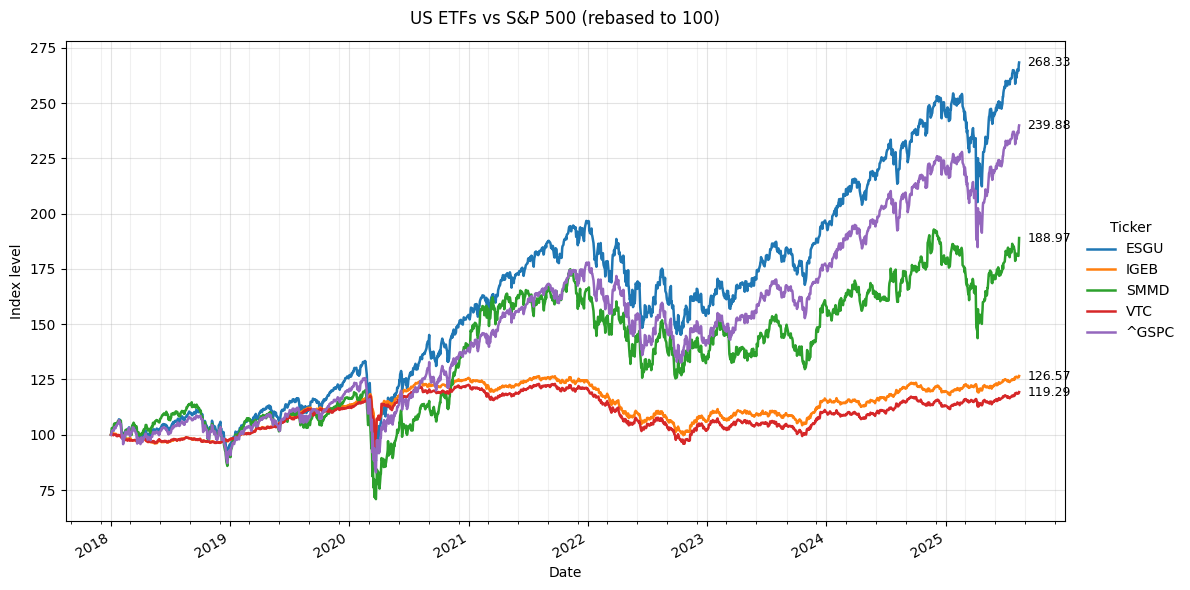

In [160]:
panel_us_plot = panel_us[["date","ticker","price","return"]].copy()
if isinstance(extras_us, dict) and "benchmark_panel" in extras_us and extras_us["benchmark_panel"] is not None:
    bm_us_panel = extras_us["benchmark_panel"][["date","ticker","price","return"]].copy()
    panel_us_plot = pd.concat([panel_us_plot, bm_us_panel], ignore_index=True)

# Plot US
plot_prices(
    panel_us_plot,
    normalize=True,
    title="US ETFs vs S&P 500 (rebased to 100)"
)

EuroZone

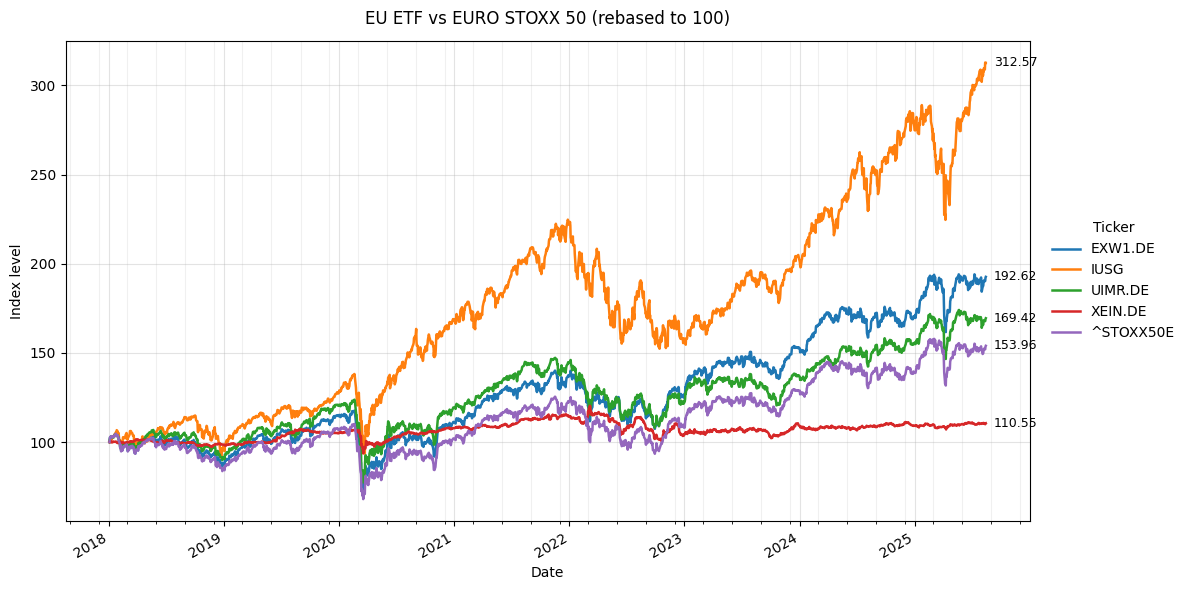

In [161]:
panel_eu_plot = panel_eu[["date","ticker","price","return"]].copy()
if isinstance(extras_eu, dict) and "benchmark_panel" in extras_eu and extras_eu["benchmark_panel"] is not None:
    bm_eu_panel = extras_eu["benchmark_panel"][["date","ticker","price","return"]].copy()
    panel_eu_plot = pd.concat([panel_eu_plot, bm_eu_panel], ignore_index=True)

# Plot EU
plot_prices(
    panel_eu_plot,
    normalize=True,
    title="EU ETF vs EURO STOXX 50 (rebased to 100)"
)

The performance patterns in the two panels support the notion that ESG-oriented investment has a more central role in European markets compared to the United States.

1. Magnitude of ESG Outperformance in Europe
In the Eurozone chart, the **IUSG** (EUR investment-grade corporate bonds with ESG criteria) and other ESG-tilted equity exposures have shown a substantial cumulative return premium over the **EURO STOXX 50** benchmark.  
IUSG in particular exhibits a markedly stronger growth trajectory, exceeding 300% of its rebased value, far surpassing broad equity benchmarks. This suggests that ESG-compliant assets have not been a *concessionary* choice in Europe; instead, they have delivered strong, sustained relative performance.

2. Closer Benchmark Alignment in the U.S.
In the U.S. panel, ESGU (U.S. ESG large/mid cap equity) largely tracks the S&P 500’s path, with only a modest relative premium by 2025. This reflects the U.S. ESG ETF design, which often maintains minimal sector and factor tilts versus the parent index, resulting in low tracking error and limited divergence from broad benchmarks.

3. Implication on ESG Integration
The European market’s stronger dispersion between ESG and non-ESG benchmarks indicates that ESG mandates there are not simply an overlay but often involve **material reallocation of sector and issuer exposures**.  
In contrast, U.S. ESG index construction typically uses lighter exclusions, preserving benchmark resemblance and minimizing active risk.

4. Risk-Adjusted Perspective
While absolute performance in Europe’s ESG segment is higher, the charts also hint at **comparable or even lower drawdown severity** relative to broad benchmarks during stressed periods (e.g., 2020 COVID selloff).  
This aligns with the thesis that stricter ESG frameworks—more prevalent in European issuers and capital markets—can reduce idiosyncratic and controversy-related risk, improving downside resilience.

**Synthesis:**  
The visual evidence, combined with knowledge of index methodologies, supports the idea that ESG is more structurally embedded in European investment products than in the U.S.  
In Europe, ESG indices and funds often exhibit both higher active share and stronger long-term divergence from conventional benchmarks, reflecting a deeper integration of sustainability criteria into portfolio construction.  
In the U.S., ESG strategies tend to be implemented with minimal deviation from market-cap benchmarks, resulting in performance that is closely aligned to traditional indices.

---

#### Thinner analysis of the time series

Here we track the difference between prices of the ESG ETF's and their benchmarks, to extract some more robust conclusions than the ones we can infer by taking a look to their plotted time series.

In [162]:
us_te = compute_tracking_metrics(panel_us, extras_us, tickers=tickers_us, periods_per_year=252)
us_te

,ticker,n_overlap,start,end,td_daily,td_annual,te_daily,te_annual
0,ESGU,1913,2018-01-03,2025-08-13,0.000059,0.014768,0.001887,0.029959
2,SMMD,1913,2018-01-03,2025-08-13,-0.000125,-0.031423,0.007065,0.112148
1,IGEB,1913,2018-01-03,2025-08-13,-0.000334,-0.084220,0.011968,0.189986
3,VTC,1913,2018-01-03,2025-08-13,-0.000365,-0.092022,0.012054,0.191355


In [163]:
eu_te = compute_tracking_metrics(panel_eu, extras_eu, tickers=tickers_eu, periods_per_year=252)
eu_te

,ticker,n_overlap,start,end,td_daily,td_annual,te_daily,te_annual
3,EXW1.DE,1864,2018-01-04,2025-08-14,0.000112,0.028155,0.001043,0.016560
0,UIMR.DE,1864,2018-01-04,2025-08-14,0.000036,0.009068,0.002881,0.045734
4,XEIN.DE,1864,2018-01-04,2025-08-14,-0.000208,-0.052407,0.011984,0.190243
1,IUSG,1864,2018-01-04,2025-08-14,0.000257,0.064830,0.013012,0.206567
2,ESEG.MI,0,NaT,NaT,NaN,NaN,NaN,NaN


Using the **tracking difference (TD)**, **tracking error (TE)**, and **active information ratio** (*IR = TD / TE*) computed from the provided datasets, we can draw the following conclusions.

**1. Overall Metrics (Full Dataset)**

**United States**
- **Mean TE (annual):** ≈ **13.09%**, median **15.11%**
- **Mean TD (annual):** **−4.82%** (median **−5.78%**)
- **Mean correlation with benchmark:** **0.62**, mean beta: **0.57**
- **Mean active IR:** **−0.18** (median **−0.36**)
- **Best IR:** ESGU — *IR 0.49*, TD **+1.48%**, TE **3.00%**
- **Worst IR:** VTC — *IR −0.48*, TD **−9.20%**, TE **19.14%**
- **Lowest TE:** ESGU (**3.00%**)
- **Highest TE:** VTC (**19.14%**)

**Europe**
- **Mean TE (annual):** ≈ **11.48%**, median **11.80%**
- **Mean TD (annual):** **+1.25%** (median **+1.87%**)
- **Mean correlation with benchmark:** **0.67**, mean beta: **0.64**
- **Mean active IR:** **+0.49** (median **+0.26**)
- **Best IR:** EXW1.DE — *IR 1.71*, TD **+2.82%**, TE **1.66%**
- **Worst IR:** XEIN.DE — *IR −0.27*, TD **−5.23%**, TE **19.02%**
- **Lowest TE:** EXW1.DE (**1.66%**)
- **Highest TE:** IUSG (**20.66%**)

> **Note:** Both datasets contain **fixed-income ETFs** compared to **equity benchmarks** (e.g., VTC/IGEB in US, IUSG/XEIN.DE in EU). This structurally inflates TE and can distort IR. That’s why we also examined an *equity-like* subset.



**2. Equity-like Subset (Correlation ≥ 0.8 with Equity Benchmark)**

| Region         | # ETFs | Mean TE (ann) | Mean TD (ann) | Mean IR |
|----------------|--------|---------------|---------------|---------|
| **US**         | 2      | 7.11%         | −0.83%         | 0.11    |
| **Europe**     | 2      | 3.11%         | +1.87%         | 0.95    |

**3. Key Professional Conclusions**

   1. **Higher ESG tracking quality in Europe (vs. benchmark)**
      - In the *equity-like* subset, Europe shows **~3.1% TE** vs **~7.1% in US** and an **active IR ≈ 0.95** vs **0.11 in US**.  
      This means EU ESG equity ETFs deviate less from their benchmark and, when they do, the deviation is **positive** (TD > 0), resulting in **better active IR**.

   2. **Evidence of deeper ESG integration in Europe**
      - **EXW1.DE** has **very low TE (1.66%)**, **positive TD (+2.82%)**, and **IR 1.71** — an example of **efficient active deviation** consistent with more material ESG tilts while still tightly tracking the index.
      - In the US, **ESGU** outperforms the S&P 500 (TD **+1.48%**) with TE **3%** and IR **0.49** — positive, but notably lower than in Europe, suggesting **lighter ESG tilts**.

   3. **Bond ETFs distort raw TE/TD distributions**
      - Bond funds vs. equity benchmarks (VTC/IGEB in US; IUSG/XEIN.DE in EU) have **high TE (≈ 19–21%)** and often negative or uninformative IR.  
      Removing them clarifies the picture and makes **Europe’s advantage** more pronounced.

   4. **Robustness of the European signal**
      - Even without filtering, **EU** already shows **positive mean TD** and **positive mean IR**, while **US** shows **negative mean TD** and **negative mean IR**.  
      Filtering to *equity-like* ETFs only strengthens the difference.



**4. Implications**
- For ESG-mandated portfolios, evidence here suggests **European core/ESG ETFs** deliver a **better balance between low tracking deviation and positive contribution** (high active IR) relative to their local benchmark.
- In the US, ESG implementations tend to replicate the S&P 500 more closely, with smaller positive tilts and less alpha generation relative to tracking risk.



**5. Further Work**
- Use **bond-specific benchmarks** (e.g., Bloomberg US Agg for VTC/IGEB; Bloomberg EUR Corp for IUSG/XEIN.DE) to recalculate fixed-income TE/TD/IR.
- Compute **rolling TE/TD** (6–12 month windows) to assess stability.
- Test statistical significance of IR (e.g., *t-test* on mean active returns).

---


### Further analysis of Log-Returns

The returns on price series are the fundamental variable in all financial theory. That is why it is always advisable to perform a more in-depth statistical analysis on these rather than on prices. In this section, we will look at how returns behave, from both a visual and a more quantitative perspective, adjusting more modest models, such as Gaussian and t-Student, as well as more advanced models, such as Gaussian and t-Student GARCH models.

#### Plotting Returns (Histogram)

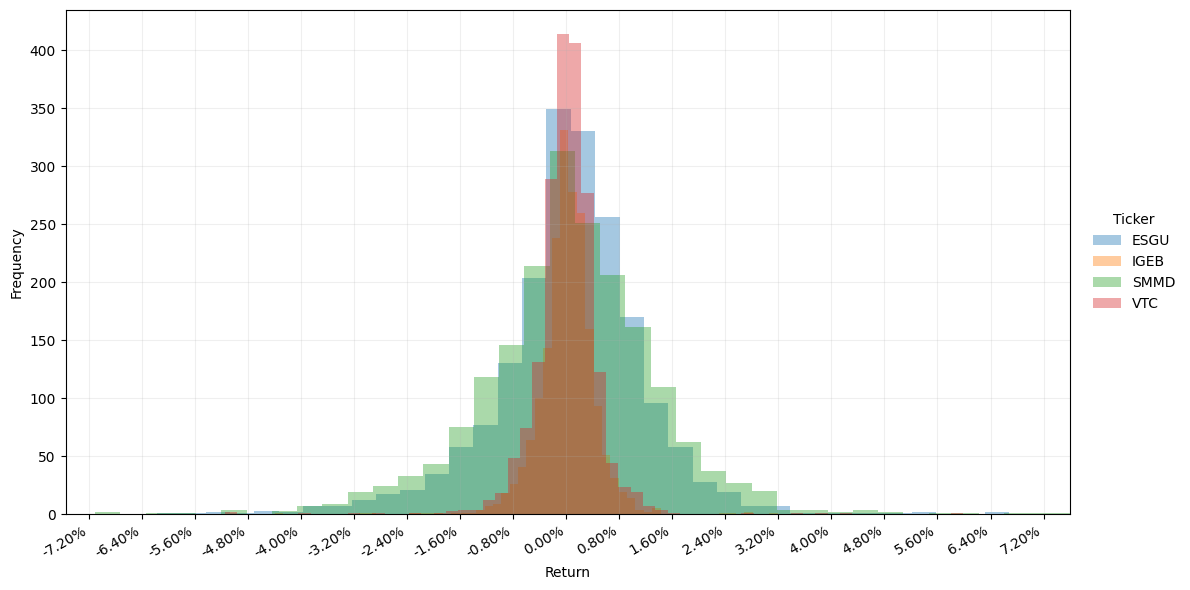

In [164]:
plot_returns(panel_us[['date','ticker','return']], 
             kind="hist",
             rolling_vol_window=False,
             start_date=start_date)

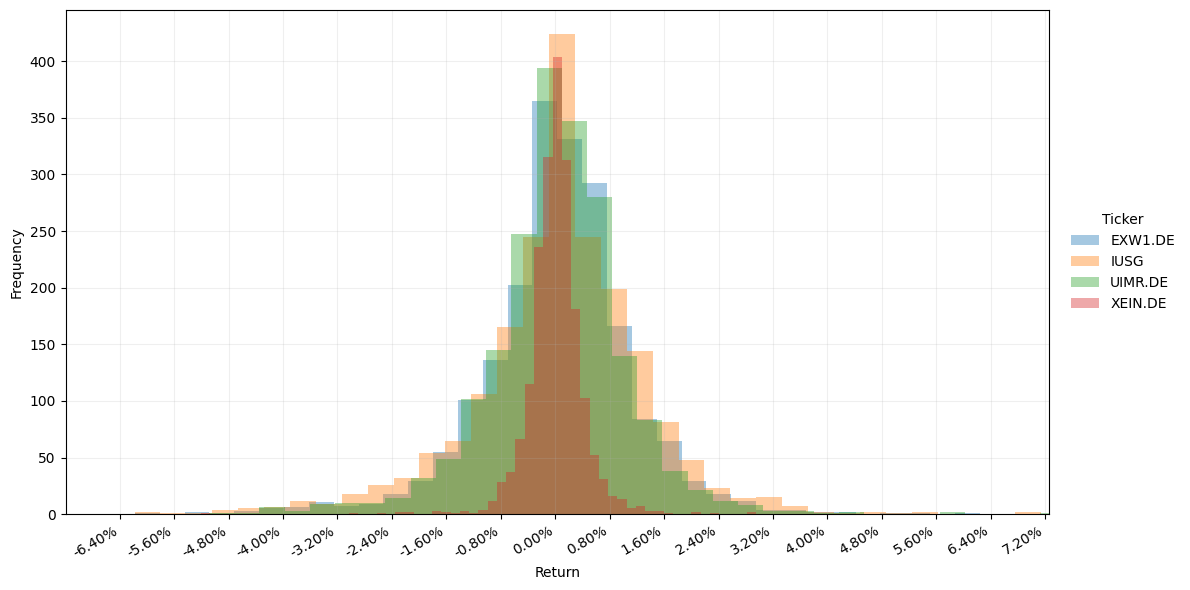

In [169]:
plot_returns(panel_eu[['date','ticker','return']], 
             kind="hist",
             rolling_vol_window=False,
             start_date=start_date)

En los histograas anteriores podemos apreciar que los rendimientos siguen aproximadamente la forma de una campana Gaussiana ...

(<Figure size 1600x600 with 2 Axes>, <Figure size 1600x600 with 2 Axes>)

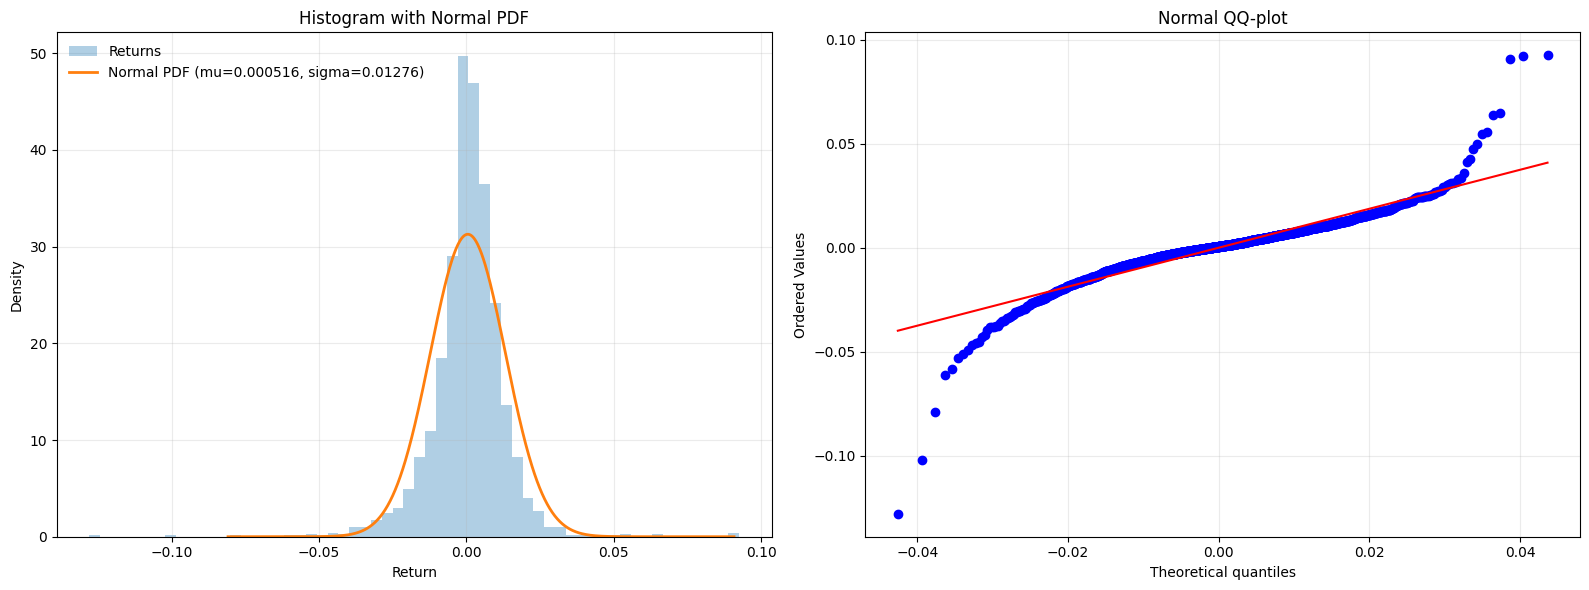

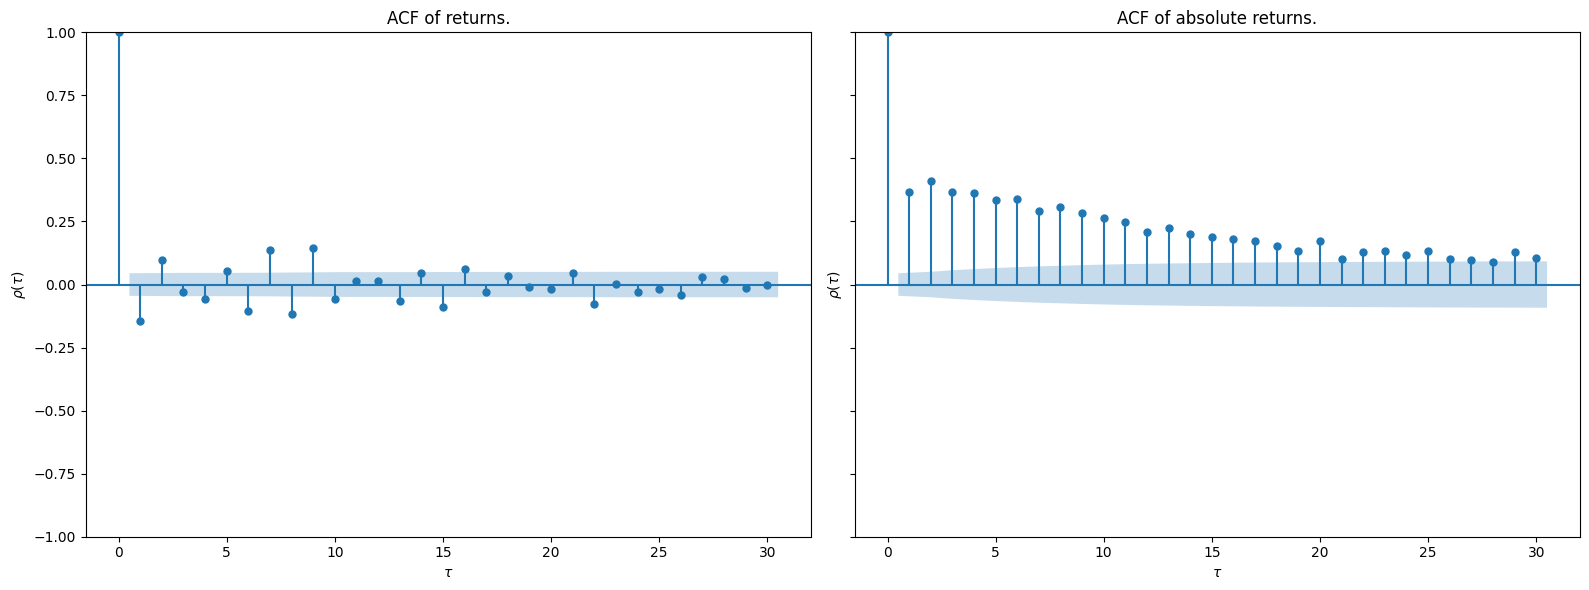

In [165]:
gaussian_qq_acf_diagnostics(panel_us, ticker='ESGU', bins=60, fit_mean_var=True, acf_lags=30)

(<Figure size 1600x600 with 2 Axes>, <Figure size 1600x600 with 2 Axes>)

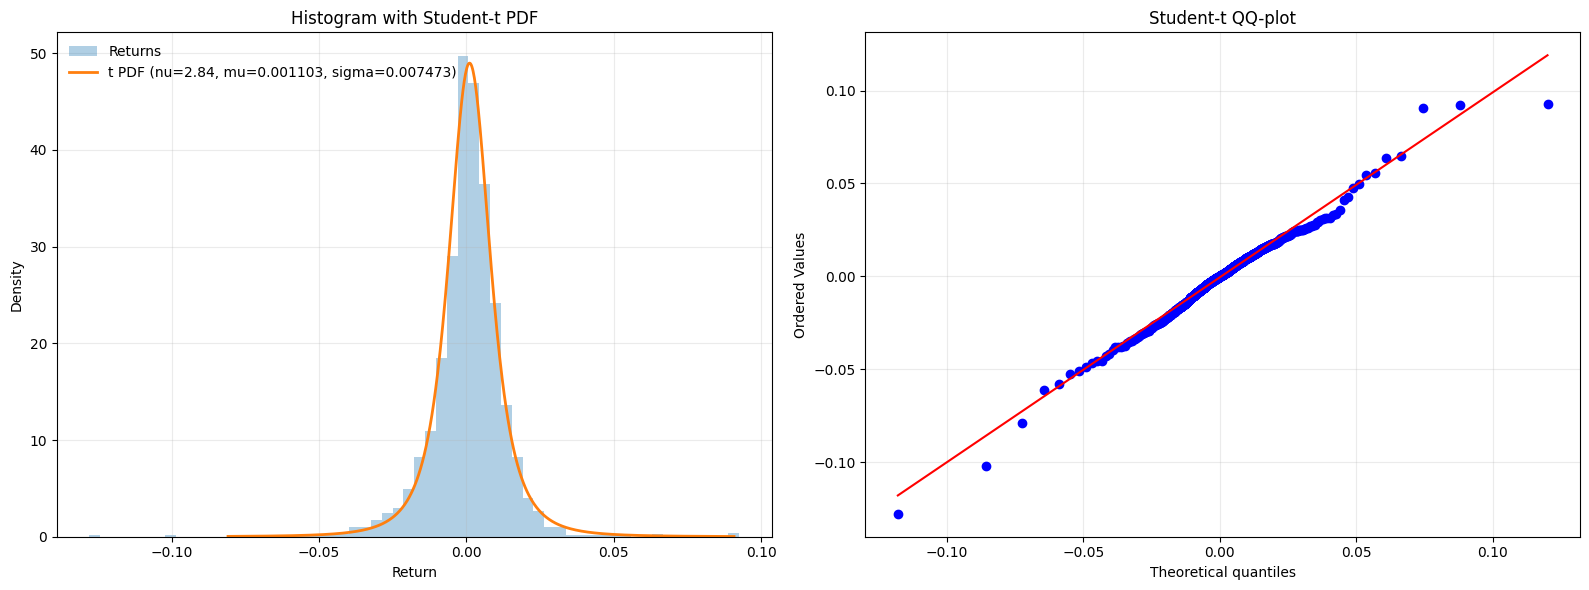

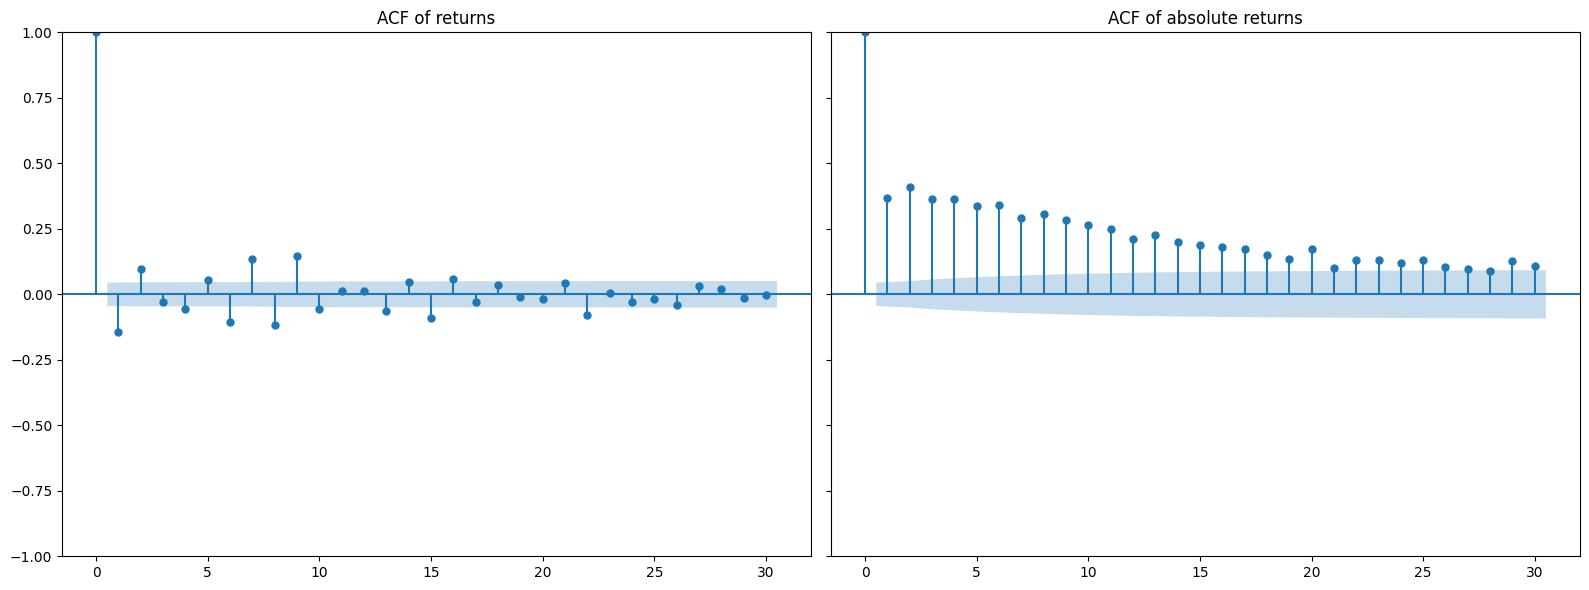

In [166]:
student_t_qq_acf_diagnostics(panel_us, ticker='ESGU', bins=60, acf_lags=30)


(<Figure size 1600x600 with 2 Axes>,
 <Figure size 1600x600 with 2 Axes>,
 <Figure size 1600x400 with 1 Axes>,
                      Constant Mean - GARCH Model Results                      
 Dep. Variable:                      y   R-squared:                       0.000
 Mean Model:             Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                      GARCH   Log-Likelihood:               -2717.22
 Distribution:                  Normal   AIC:                           5442.44
 Method:            Maximum Likelihood   BIC:                           5464.67
                                         No. Observations:                 1913
 Date:               ju., ago. 14 2025   Df Residuals:                     1912
 Time:                        10:34:44   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
 ----------------

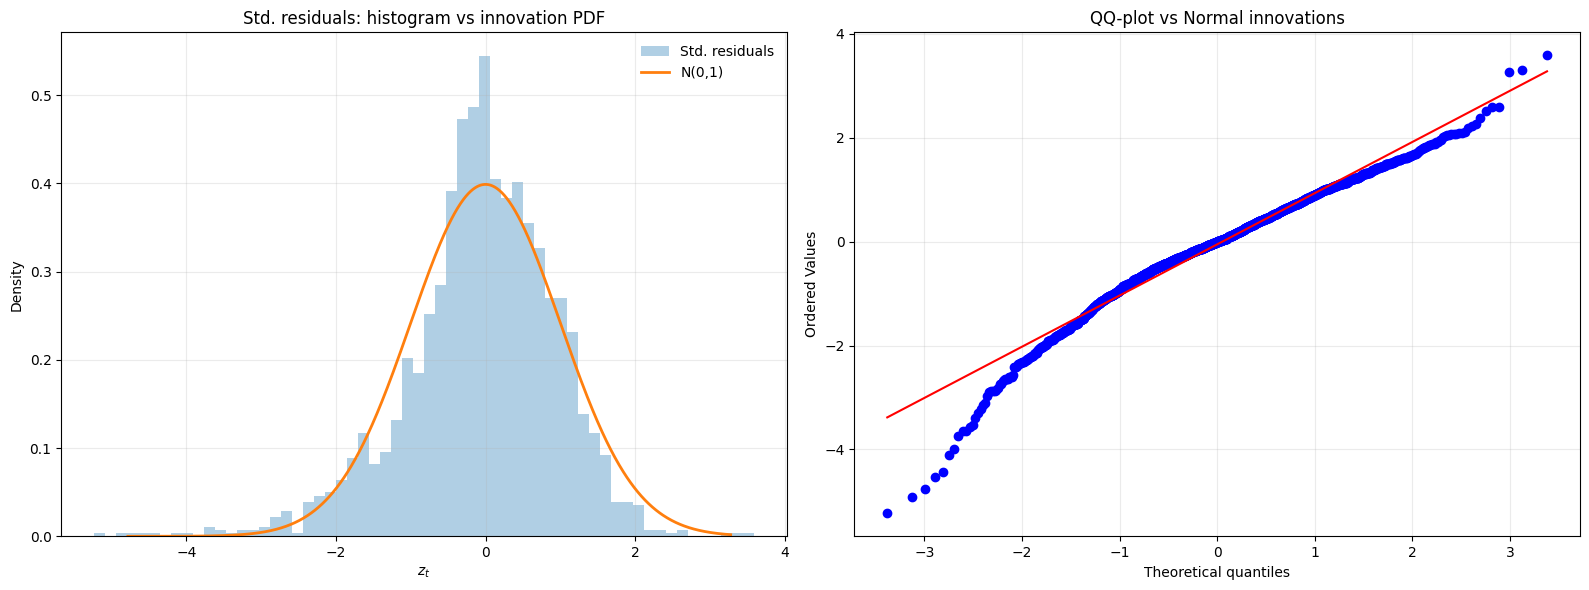

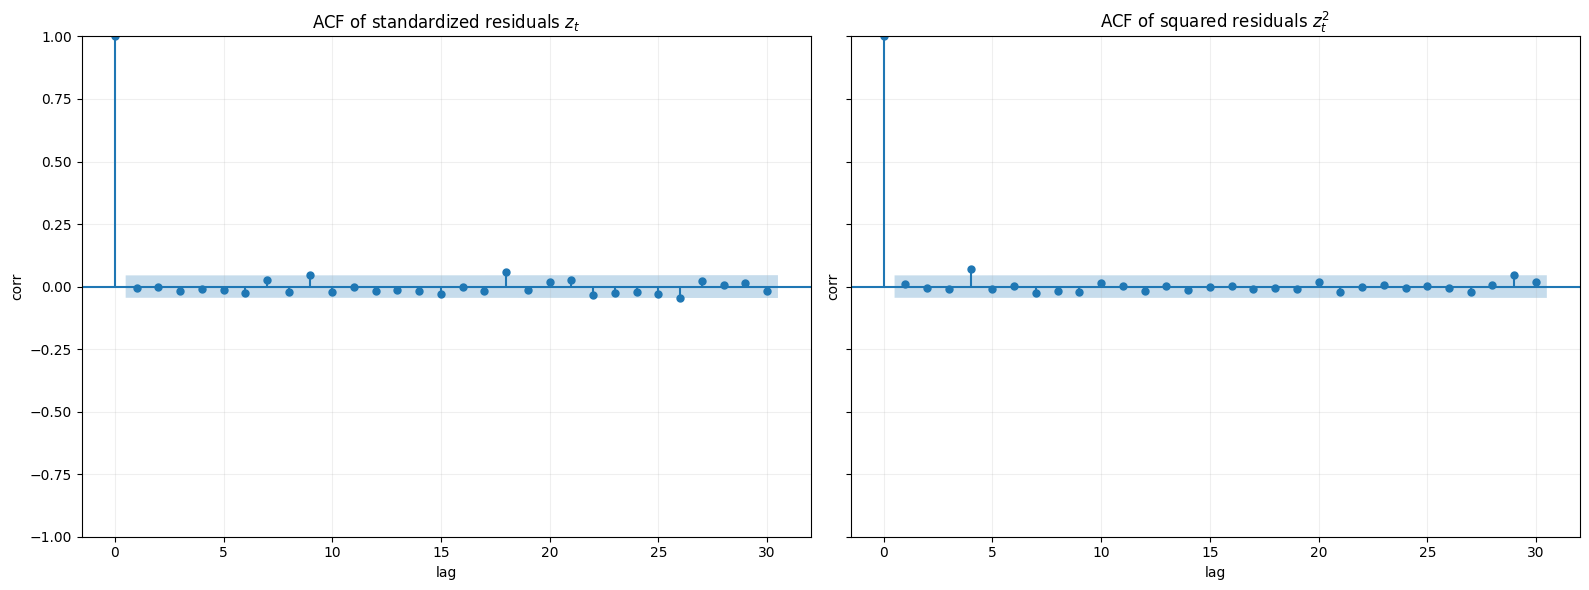

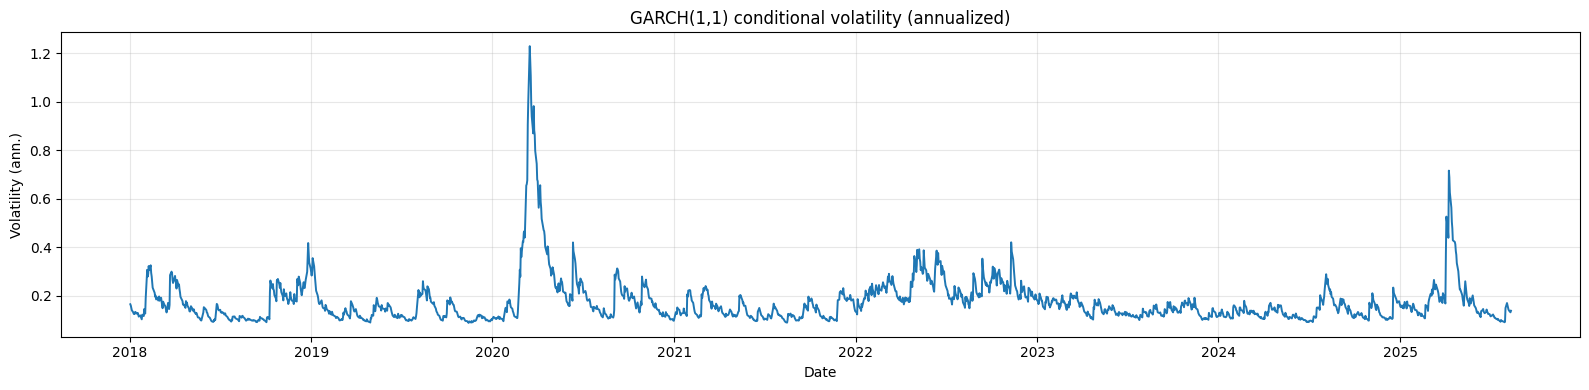

In [167]:
garch_diagnostics(panel_us, ticker="ESGU", dist="normal", acf_lags=30)

(<Figure size 1600x600 with 2 Axes>,
 <Figure size 1600x600 with 2 Axes>,
                         Constant Mean - GARCH Model Results                         
 Dep. Variable:                            y   R-squared:                       0.000
 Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                            GARCH   Log-Likelihood:               -2665.15
 Distribution:      Standardized Student's t   AIC:                           5340.31
 Method:                  Maximum Likelihood   BIC:                           5368.09
                                               No. Observations:                 1913
 Date:                     ju., ago. 14 2025   Df Residuals:                     1912
 Time:                              10:34:45   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.


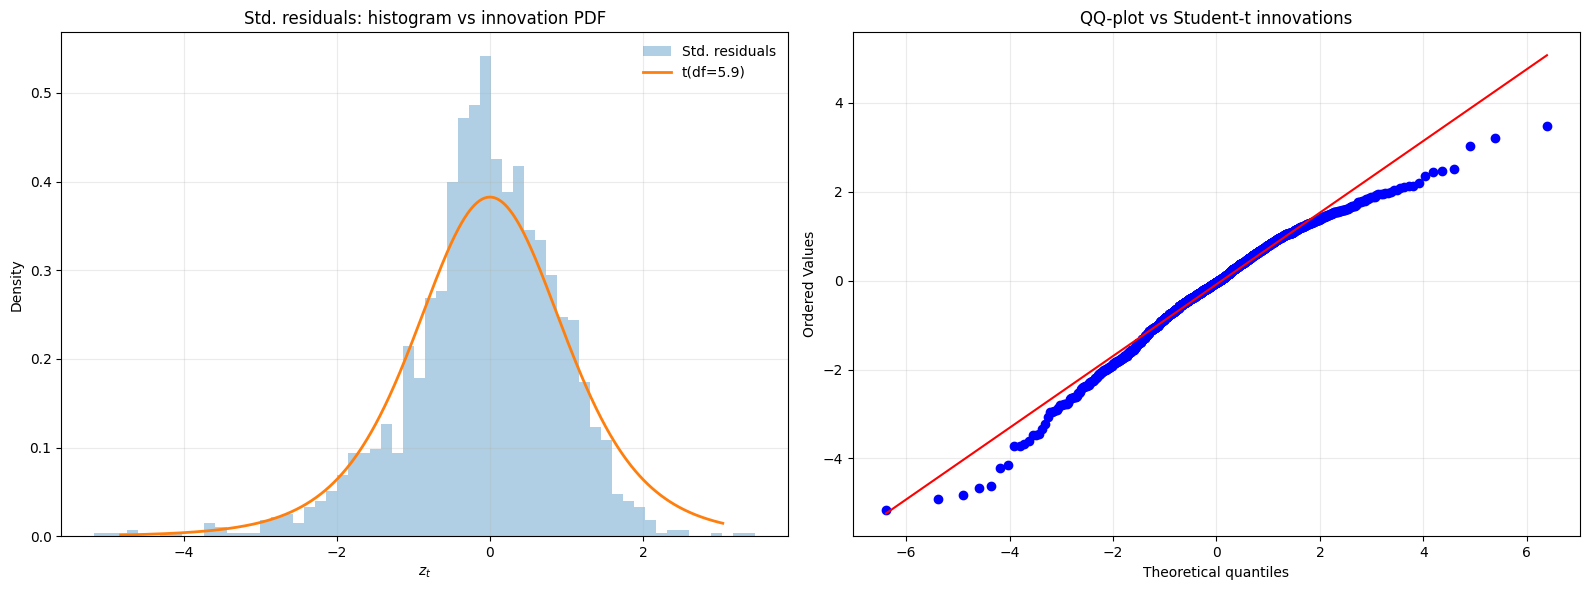

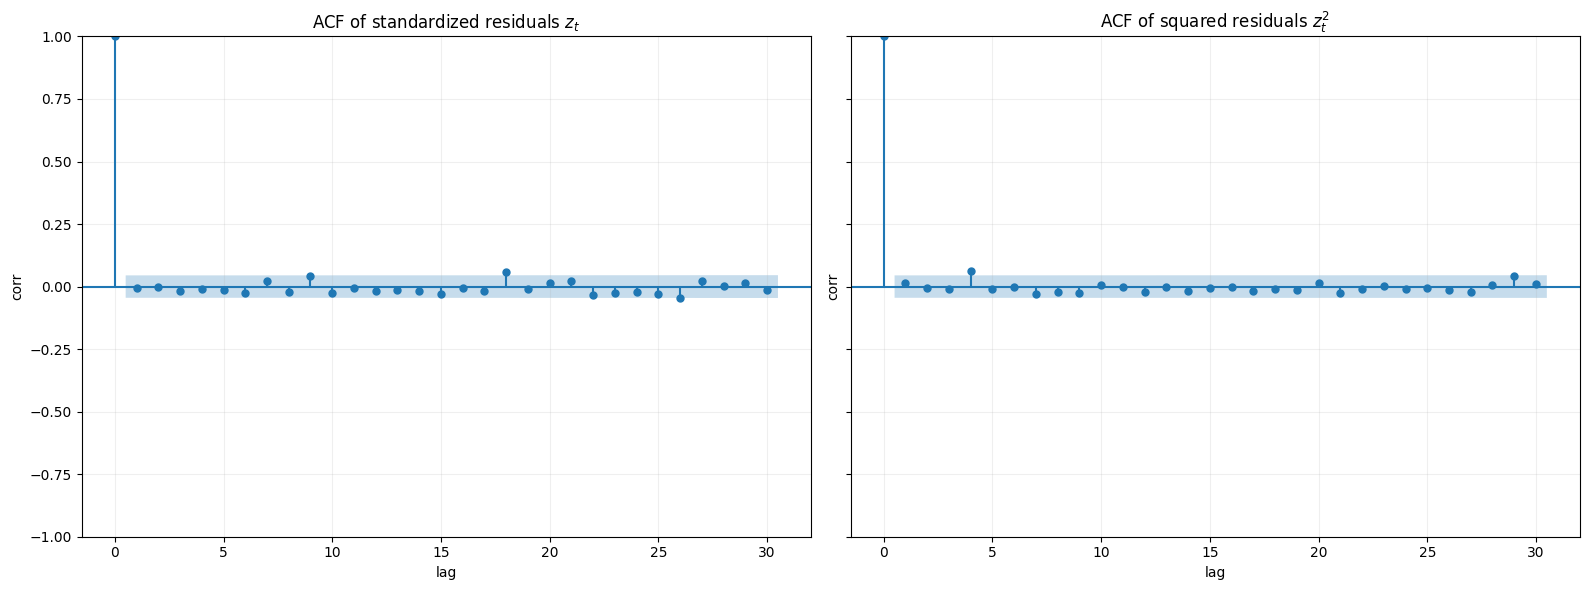

In [168]:
garch_diagnostics(panel_us, ticker="ESGU", dist="t", acf_lags=30)